In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from joblib import Parallel, delayed
import multiprocessing
import operator
from utils import train_test_indexes

%matplotlib inline
import mpld3
#mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

http://www10.org/cdrom/papers/577/

(28418,) (18945,)


# Tests

In [ ]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

In [191]:
#n = 52
#n = 67
#n = 85

n=67

ranks = train['resultsId'][n,:,:5]
ranks = ranks.T

print ranks

label = train['probeLabel'][n,0]
target_id = train['galleryId'][[train['galleryLabel']==label]]

print
print 'target Id',target_id

[[145226   2665   2665   2665 140918  58582  58582  30028]
 [ 70291  33348  62503  72088  62845   6067 138347  65975]
 [109615  78188  86644 137084  60166  86644 134051  58582]
 [ 37310  58582 107464 109615 137084  54020 140918  50991]
 [ 31929  12649  57654  57654 157455 140918   6067  97147]]

target Id [58582]


In [43]:
rank = ranks[:2,:]
print rank

#print np.argwhere(rank==41004)[0][0], np.argwhere(rank==78881)[0][0]

print np.sum(rank, axis=0)

[[ 41004  78881  41004  41004  41004  41004  41004  41004]
 [ 29667  41004  78720 116675 116675 136984 149514  21764]]
[ 70671 119885 119724 157679 157679 177988 190518  62768]


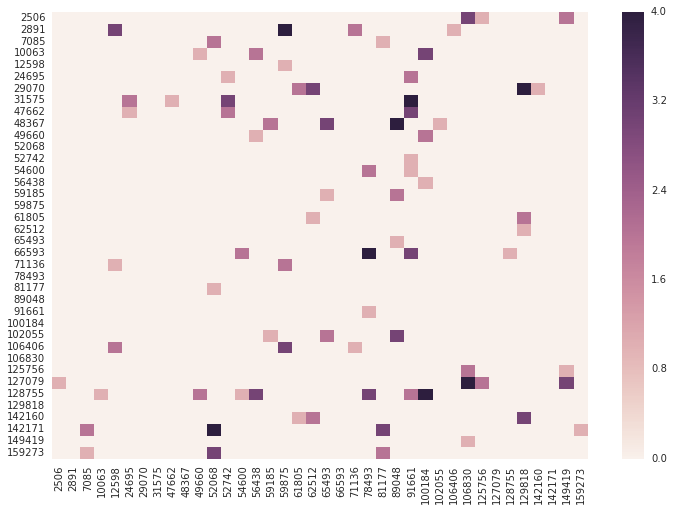

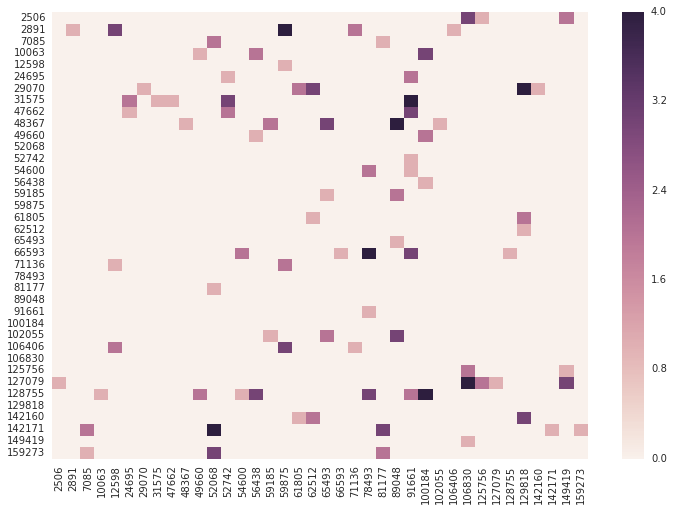

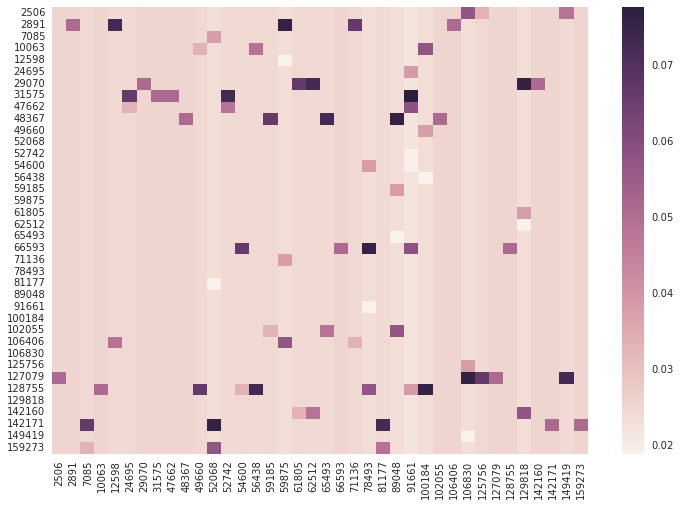

In [161]:
uniques = np.unique(ranks)

transit = np.zeros((len(uniques), len(uniques)))


for i in range(len(uniques)):
    for j in range(len(uniques)):
        for col in range(8):
            rank = ranks[:,col]
            if i!=j and uniques[i] in rank and uniques[j] in rank:
                posi = np.argwhere(rank==uniques[i])[0][0]
                posj = np.argwhere(rank==uniques[j])[0][0]
                if posi > posj:
                    transit[j,i] += 1.*(posi-posj)
                elif posi < posj:
                    transit[j,i] -= 1.*(posj-posi)

transit[transit<0.] = 0.
#transit[transit>0.] = 1.

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

all_zero_columns_index = np.where(~transit.any(axis=0))[0]
transit[all_zero_columns_index, all_zero_columns_index] = 1.



fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

sums = np.sum(transit, axis=0)
transit = np.divide(transit, sums)

#transit = transit + 5e-2
for i in range(len(transit)):
    probs = transit[:,i]
    count = len(probs[probs!=0.])
    probs[probs == 0] = 5e-1/float(count)
    transit[:,i] = probs

sums = np.sum(transit, axis=0)
transit = np.divide(transit, sums)

transit[transit == np.nan] = 0.

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
number of iterations 3
predicted id: 128755 ,  target id: 142171

[128755  31575 142171   2891 127079  29070  48367  66593  47662   2506
 142160 106406 102055 159273  10063]


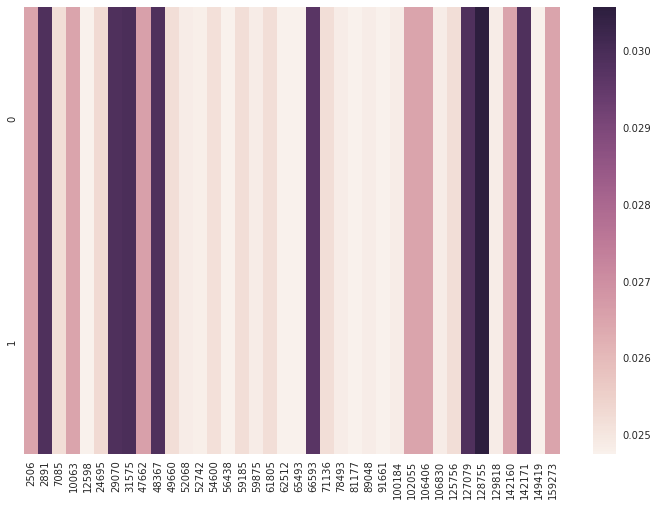

In [162]:
print np.sum(transit, axis=0)


tol = 1e-5
max_rounds= 1000

label_proba2 = np.ones(len(uniques))*1./len(uniques)

i = 0
diff = 1.
while diff >= tol and i <= max_rounds:
    label_proba1 = label_proba2
    label_proba2 = transit.dot(label_proba1)
    diff = np.linalg.norm(label_proba2 - label_proba1)
    i += 1
    
print 'number of iterations', i

label = label_proba2

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(np.vstack((label,label)), xticklabels=uniques, ax=ax)

max_label = uniques[np.argmax(label)]

print 'predicted id:', max_label, ',  target id:', target_id[0]
print
ind = np.argsort(-label)
print uniques[ind][:15]

# Utilisation de la méthode sur les données train

In [134]:
from markov_chains import find_label

train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')
train_ind, test_ind = train_test_indexes(test_size=0.1)

print train_ind.shape, test_ind.shape

(42627,) (4736,)


In [135]:
predIds = train['resultsId'][train_ind,:,:15]
probeIds = train['probeId'][train_ind,0]


num_cores = multiprocessing.cpu_count()
best_Ids = Parallel(n_jobs=num_cores - 2)(delayed(find_label)(predIds[i,:,:], probeIds[i], eps=1e-1, tol=1e-5) 
                                          for i in range(len(predIds)))
   

KeyboardInterrupt: 

In [125]:
best_ids2 = best_Ids

best_ids2 = {k.keys()[0]: k.values()[0] for k in best_ids2}

print best_ids2

{0: 67575, 1: 158206, 131077: 71012, 131079: 98873, 10: 110267, 14: 56700, 17: 89515, 18: 109361, 19: 158922, 24: 66408, 131100: 128785, 29: 111339, 5: 126884, 131104: 66414, 131106: 58876, 36: 113092, 38: 118525, 40: 26624, 131114: 37572, 53: 70841, 54: 136067, 131082: 28347, 62: 106062, 131135: 137118, 131136: 47185, 69: 102519, 72: 106966, 73: 68158, 131147: 135743, 76: 14922, 131153: 28512, 84: 120498, 87: 121248, 90: 134542, 131164: 30974, 131165: 86096, 131169: 31841, 131174: 99809, 107: 58629, 13094: 108625, 131183: 15079, 131185: 48965, 131187: 77194, 131191: 118, 121: 145414, 123: 137263, 127: 152482, 131: 9005, 132: 53660, 131205: 43616, 134: 157109, 131208: 46323, 145: 136886, 146: 77672, 147: 62525, 131221: 34949, 131223: 118285, 153: 29799, 131226: 48212, 21871: 110071, 156: 122087, 157: 123214, 131231: 60615, 131233: 18794, 162: 38671, 163: 71155, 131239: 112759, 131242: 98351, 131248: 111296, 177: 150250, 131251: 70155, 180: 93370, 131253: 114041, 185: 66287, 186: 117507

In [99]:
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}
probes = { train['probeId'].ravel()[i]: train['probeLabel'].ravel()[i] for i in range(len(train['probeLabel']))}

In [126]:
preds = np.asarray([int(gallery[best_ids2[i]]) for i in probeIds.ravel()])
probes_label = np.asarray([probes[i] for i in probeIds.ravel()])

print len(preds), len(probes_label)
print preds
print probes_label

accuracy = np.mean(preds == probes_label)


print
print(accuracy)


42627 42627
[13721 13722 48061 ..., 37873 37874 37875]
[13721 13722 48061 ..., 37873 37874 37875]

0.971754990968


# Sur les données test

In [127]:
test = io.loadmat('/home/max/projects/challengeMDI343/data/data_test.mat')

In [128]:
predIds = test['resultsId'][:,:,:7]
probeIds = test['probeId'][:,0]


num_cores = multiprocessing.cpu_count()
best_Ids = Parallel(n_jobs=num_cores - 2)(delayed(find_label)(predIds[i,:,:], probeIds[i], eps=1e-1, tol=1e-5) 
                                          for i in range(len(predIds)))

In [129]:
best_ids2 = best_Ids

best_ids2 = {k.keys()[0]: k.values()[0] for k in best_ids2}

print best_ids2

{1048579: 1083612, 1048580: 1099743, 1048582: 1003482, 1048585: 1045174, 1048588: 1018457, 1048591: 1074221, 1048593: 1015771, 1048599: 1059016, 1048603: 1066529, 1048608: 1010438, 1048609: 1071998, 1048614: 1001924, 1048615: 1058361, 1048621: 1133149, 1048624: 1134823, 1048627: 1075600, 1048629: 1092020, 1026740: 1067808, 1048634: 1035262, 1048635: 1034476, 1048648: 1050468, 1048649: 1077536, 1026743: 1094795, 1048652: 1021853, 1048659: 1064802, 1048660: 1152668, 1048664: 1094777, 1048667: 1026068, 1048668: 1088705, 1157818: 1035044, 1048671: 1000731, 1048675: 1018820, 1048677: 1069610, 1048680: 1076538, 1048683: 1107383, 1048685: 1120922, 1157821: 1056253, 1048688: 1120294, 1048689: 1040854, 1048694: 1112528, 1048695: 1098770, 1048696: 1046046, 1048697: 1048544, 1048698: 1146476, 1048704: 1032533, 1048716: 1059062, 1048717: 1106894, 1048727: 1049971, 1048741: 1021036, 1048742: 1153003, 1048743: 1043218, 1048744: 1091650, 1048756: 1157560, 1048757: 1013685, 1048759: 1107102, 1048760: 

In [132]:
gallery = {test['galleryId'].ravel()[i]: test['galleryLabel'].ravel()[i] for i in range(len(test['galleryLabel']))}

In [133]:
preds = np.asarray([int(gallery[best_ids2[i]]) for i in probeIds.ravel()])

print preds

print preds.shape

np.savetxt('soumission7.txt', preds, fmt='%i')

[1008859 1008860 1008861 ..., 1044363 1044364 1044365]
(47361,)


# Test de l'aggrégation de plusieurs chaines de Markov

In [165]:
from markov_chains import new_rankings

In [163]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

In [204]:
#n = 52
#n = 67
#n = 85
n=67

ranks = train['resultsId'][n,:,:15]
ranks2 = ranks.T

print ranks2

label = train['probeLabel'][n,0]
target_id = train['galleryId'][[train['galleryLabel']==label]]

print
print 'target Id',target_id

[[145226   2665   2665   2665 140918  58582  58582  30028]
 [ 70291  33348  62503  72088  62845   6067 138347  65975]
 [109615  78188  86644 137084  60166  86644 134051  58582]
 [ 37310  58582 107464 109615 137084  54020 140918  50991]
 [ 31929  12649  57654  57654 157455 140918   6067  97147]
 [ 73391 137084  87355  86644   6067  37310  30028 142931]
 [ 67084  87355  58582  50991  39733 157771  97855 140918]
 [126383  86644  78188 140918 115231 158799  60166   2665]
 [138118 107464  60166  58582 143143 138347  33348 106340]
 [113464 140918  62845  60166  80695  33348 130320  34712]
 [ 90081 137199 137084  56812 149483 145124  25668  86644]
 [154281  57654  86638  56405 117873  10477 107892  35293]
 [ 99496 145414  41375  47947 117593   3104  27157  12649]
 [  9598 114773  33348  67339  79097 152984 128438 114773]
 [  2665  65975 140918  87355   9587  91455 150057 104330]]

target Id [58582]


In [205]:
rankings = new_rankings(ranks, 1, seed=8)

print rankings

rankings = new_rankings(rankings.T,1, seed=1)

print
print rankings

rankings = new_rankings(rankings.T,1, seed=2)

print
print rankings

big matrix: (8, 75, 75)
[[  58582.    2665.    2665.   58582.   58582.    2665.    2665.   58582.]
 [ 140918.   58582.   58582.    2665.  140918.   58582.   58582.    2665.]
 [  86644.  140918.  140918.  145226.    2665.  140918.  145226.  140918.]
 [   6067.   86644.  145226.  140918.   86644.   86644.  140918.  145226.]
 [   2665.    6067.    6067.    6067.    6067.  145226.    6067.    6067.]
 [ 137084.   60166.   86644.  137084.  137084.    6067.   86644.   86644.]
 [  60166.  137084.  137084.   86644.  109615.  109615.  137084.  137084.]
 [ 109615.   37310.  109615.  109615.   30028.   30028.  109615.  109615.]
 [  30028.  138347.   60166.   60166.   60166.  137084.   30028.   60166.]
 [  37310.   30028.   37310.   37310.   37310.   70291.   70291.   37310.]
 [ 138347.  109615.   30028.   30028.   50991.   72088.   62845.   30028.]
 [  33348.  145226.  138347.  138347.   33348.   62845.  138347.  138347.]
 [ 145226.   62845.   70291.   62503.   62845.   37310.   60166.   50991.]
 